In [1]:
import os
import datetime
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from harc_plot import geopack
%matplotlib inline

Re = 6371 # Radius of the Earth in km

In [2]:
mpl.rcParams['font.size']      = 12
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

## Define Station Locations

In [3]:
tx = {}
tx['st_id'] = 'WWV'
tx['lat']   =  40.68
tx['lon']   = -105.04

In [4]:
grapes = []

g = {}
g['st_id'] = 'kd2uhn'
g['lat']   =  40.6332
g['lon']   = -74.98881
g['color'] = 'purple'
grapes.append(g)

g = {}
g['st_id'] = 'n2rkl'
g['lat']   =  43.16319
g['lon']   = -76.12535
g['color'] = 'green'
grapes.append(g)

g = {}
g['st_id'] = 'n8obj'
g['lat']   =  41.321963
g['lon']   = -81.504739
g['color'] = 'cyan'
grapes.append(g)

grapes = pd.DataFrame(grapes)
grapes = grapes.set_index('st_id')
grapes

,lat,lon,color
st_id,,,
kd2uhn,40.633200,-74.988810,purple
n2rkl,43.163190,-76.125350,green
n8obj,41.321963,-81.504739,cyan


## Calculate midpoints between Transmitter and Receivers

In [5]:
grapes

grapes_new = []
for rinx, row in grapes.iterrows():
    # print(rinx)
    lat = row['lat']
    lon = row['lon']
    
    azm = geopack.greatCircleAzm(tx['lat'],tx['lon'],lat,lon)
    rng = geopack.greatCircleDist(tx['lat'],tx['lon'],lat,lon)*Re
    res = geopack.greatCircleMove(tx['lat'],tx['lon'],rng/2.,azm,alt=0,Re=Re)
    
    row['mid_lat'] = res[0][0]
    row['mid_lon'] = res[1][0]
    
    grapes_new.append(row)
    
grapes = pd.DataFrame(grapes_new)
grapes

,lat,lon,color,mid_lat,mid_lon
kd2uhn,40.633200,-74.988810,purple,41.644169,-90.009011
n2rkl,43.163190,-76.125350,green,42.839187,-90.870155
n8obj,41.321963,-81.504739,cyan,41.604411,-93.330499


## Load Eclipse Data

In [6]:
class EclipseData(object):
    def __init__(self,fname):
        """
        Load a CSV containing eclipse obscuration data.
        """
        df = pd.read_csv(fname)

        height = df['height'].unique()
        n_heights = len(height)
        assert n_heights  == 1, f'One height expected, got: {n_heights}'
        height = height[0]

        # Calculate vectors of center lats and lons.
        center_lats = np.sort(df['lat'].unique())
        center_lons = np.sort(df['lon'].unique())

        # Find the lat/lon step size.
        dlat = center_lats[1] - center_lats[0]
        dlon = center_lons[1] - center_lons[0]

        # Calculate vectors of boundary lats and lons.
        lat_0   = center_lats.min() - dlat/2.
        lat_1   = center_lats.max() + dlat/2.
        lats    = np.arange(lat_0,lat_1+dlat,dlat)

        lon_0 = center_lons.min() - dlon/2.
        lon_1 = center_lons.max() + dlon/2.
        lons    = np.arange(lon_0,lon_1+dlon,dlon)
        
        # These if statements are to handle an error that can occur
        # when dlat or dlon are very small and you get the wrong number
        # of elements due to a small numerical error.
        if len(lats) > len(center_lats)+1:
            lats=lats[:len(center_lats)+1]

        if len(lons) > len(center_lons)+1:
            lons=lons[:len(center_lons)+1]


        cshape      = (len(center_lats),len(center_lons))
        
        self.df          = df
        self.center_lats = center_lats
        self.center_lons = center_lons
        self.cshape      = cshape
        self.lats        = lats
        self.lons        = lons
        self.dlat        = dlat
        self.dlon        = dlon
        self.height      = height
        
    def get_obsc_arr(self,obsc_min=0,obsc_max=1):
        df = self.df.copy()
        
        if obsc_min > 0:
            tf = df['obsc'] < obsc_min
            df.loc[tf,'obsc'] = np.nan
            
        if obsc_max < 1:
            tf = df['obsc'] > obsc_max
            df.loc[tf,'obsc'] = np.nan
            
        obsc_arr    = df['obsc'].to_numpy().reshape(self.cshape)
        
        return obsc_arr
    
eclipses = {}
ecl_dict =  {'fname':'data/eclipse_calc/20231014.1400_20231014.2100_300kmAlt_0.2dlat_0.2dlon/20231014.1400_20231014.2100_300kmAlt_0.2dlat_0.2dlon_MAX_OBSCURATION.csv.bz2'}
ecl_dict['obsc_min']      = 0.85
ecl_dict['alpha']         = 0.25
ecl_dict['cmap']          = mpl.cm.Purples
eclipses[2023] = ecl_dict

ecl_dict = {'fname':'data/eclipse_calc/20240408.1500_20240408.2100_300kmAlt_0.2dlat_0.2dlon/20240408.1500_20240408.2100_300kmAlt_0.2dlat_0.2dlon_MAX_OBSCURATION.csv.bz2'}
# ecl_dict = {'fname':'data/eclipse_calc/20240408.1500_20240408.2100_300kmAlt_0.1dlat_0.1dlon/20240408.1500_20240408.2100_300kmAlt_0.1dlat_0.1dlon_MAX_OBSCURATION.csv.bz2'}

ecl_dict['obsc_min']      = 0.975
eclipses[2024] = ecl_dict

for ecl_year,ecl_dict in eclipses.items():
    fname    = ecl_dict['fname']
    ecl_dict['ecl_data'] = EclipseData(fname)

## Plot on a Map

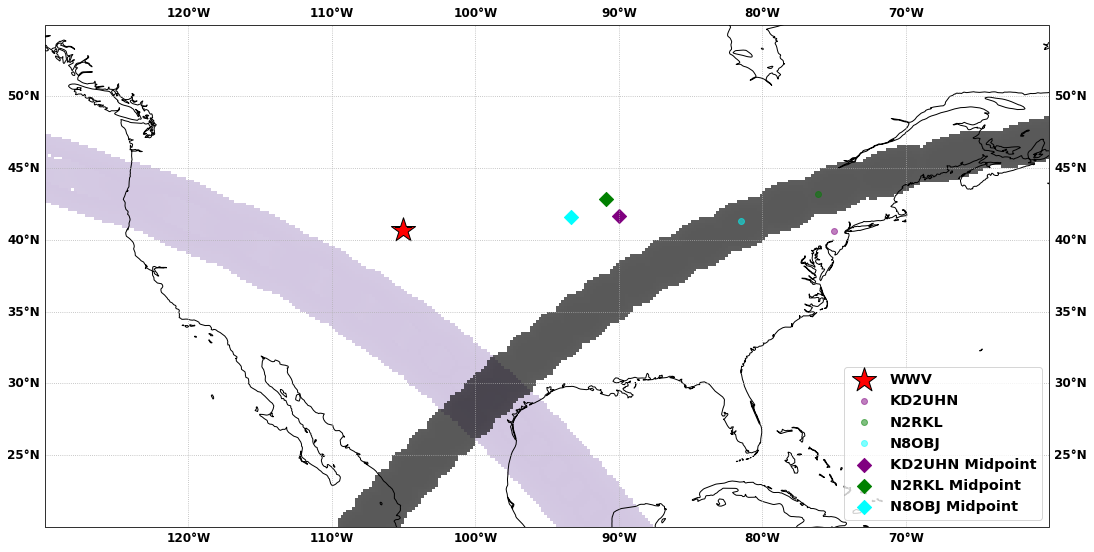

In [7]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax  = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)

for ecl_year,ecl_dict in eclipses.items():
    ecl      = ecl_dict['ecl_data']
    obsc_min = ecl_dict.get('obsc_min',0)
    alpha     = ecl_dict.get('alpha',0.65)
    cmap     = ecl_dict.get('cmap',mpl.cm.gray_r)
    lats     = ecl.lats
    lons     = ecl.lons
    obsc_arr = ecl.get_obsc_arr(obsc_min=obsc_min)
    pcoll    = ax.pcolormesh(lons,lats,obsc_arr,vmin=0,vmax=1,cmap=cmap,zorder=1,alpha=alpha)

alpha = 0.5
# Plot Transmitter
ax.scatter(tx['lon'],tx['lat'],marker='*',s=650,color='r',label=tx['st_id'],ec='black')

# Plot Ground Locations of Grapes
for rinx,row in grapes.iterrows():
    lat   = row['lat']
    lon   = row['lon']
    label = rinx.upper()
    color = row['color']
    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],alpha=alpha)
    
# Plot Grape Midpoints
for rinx,row in grapes.iterrows():
    lat   = row['mid_lat']
    lon   = row['mid_lon']
    label = '{!s} Midpoint'.format(rinx.upper())
    color = row['color']

    ax.scatter([lon],[lat],label=label,c=[mpl.colors.to_rgb(color)],marker='D',s=100)

ax.legend(loc='lower right',fontsize='large')
    
# # World Limits
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

# US Limits
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)

plt.show()